In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

# Intruduction

In this notebook we will perform some exploratory data analysis and then we will apply various machine learning models to our data

### Dataset

We will peform our analisys on the GTZAN dataset, a well-known benchmark dataset used in the field of music genre classification.  

The dataset was taken from here: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



The structure of the dataset is as follows:

- **Genres original**: A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)

- **Images original**: A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible.

- **Spectrograms**: Spectrogram of the genres original '.wav' files generated by us

- **2 CSV files**: Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file. The other file has the same structure, but the songs were split before into 3 seconds audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better.

# Exploring the data

## 30s dataset

In [ ]:
data_30s = pd.read_csv("/content/features_30_sec.csv")
data_30s = data_30s.drop('length', axis=1)
data_30s.set_index('filename', inplace=True)
data_30s.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
filename,,,,,,,,,,,,,,,,,,,,,
blues.00000.wav,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
blues.00001.wav,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
blues.00002.wav,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
blues.00003.wav,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
blues.00004.wav,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


### Correlation heatmap for the features

<Axes: >

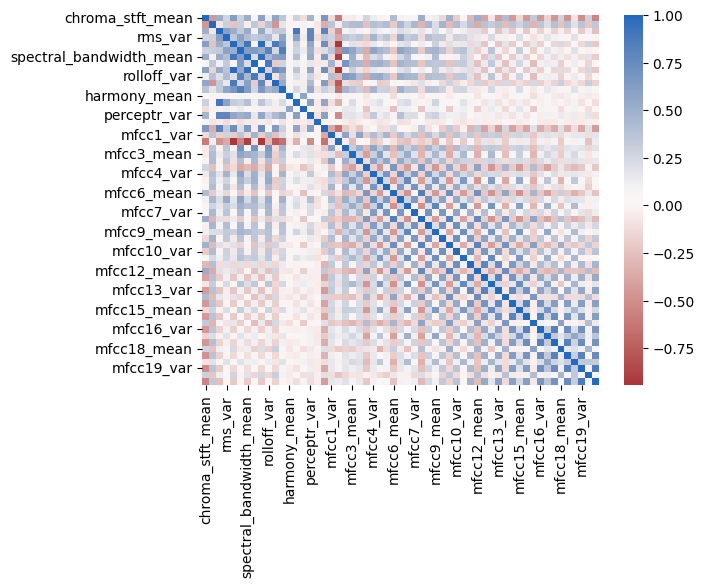

In [ ]:
sns.heatmap(data_30s.loc[:, data_30s.columns != 'label'].corr(), annot = False, cmap = 'vlag_r')

### Violin Plots

Here we can see various distributions of the features for each genre

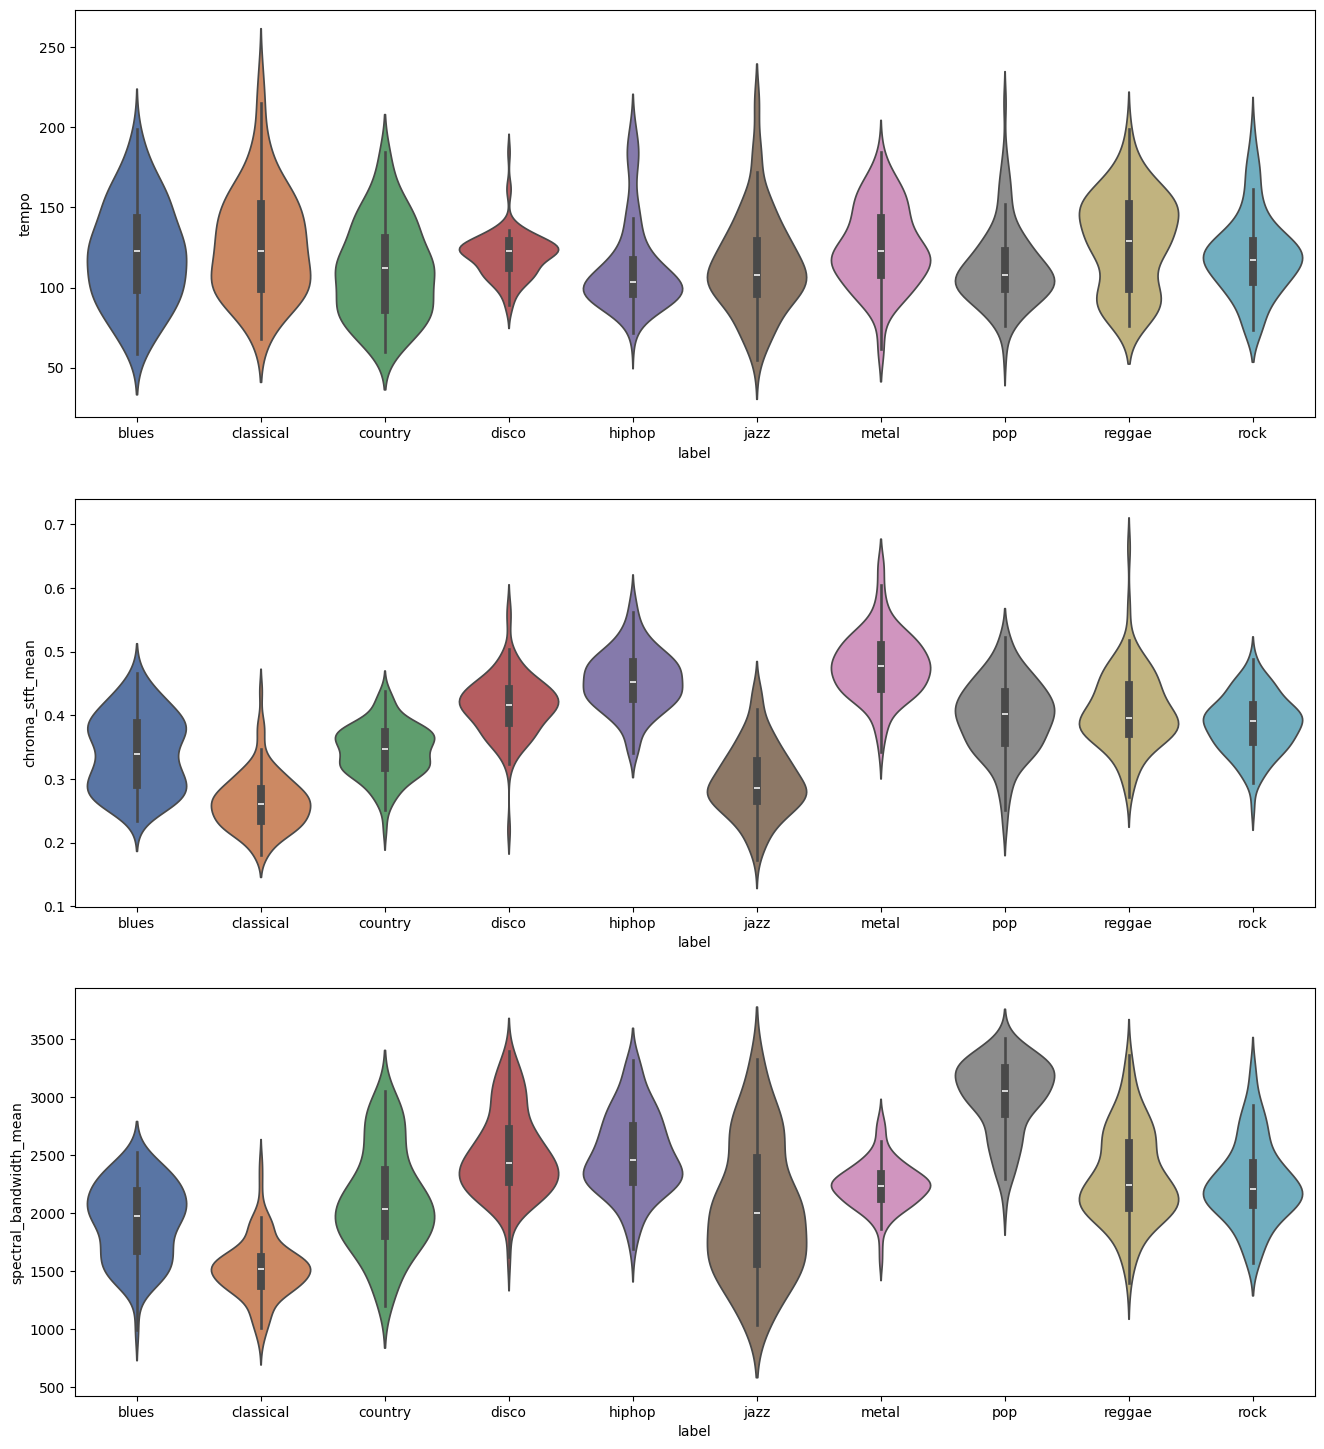

In [ ]:
distributions = ['tempo', 'chroma_stft_mean', 'spectral_bandwidth_mean']
n_distributions = len(distributions)


fig, axs = plt.subplots(1*n_distributions , 1, figsize=(16, 6*n_distributions ))
axs = axs.flatten()

for i in range(n_distributions):
  sns.violinplot(data = data_30s, ax = axs[i], x = 'label', y = distributions[i], hue='label', palette='deep')

### PCA

Here we perform the PCA on the dataset

In [ ]:
from sklearn import preprocessing

# Here we normalize our data
standard_scaler = preprocessing.StandardScaler()

data_30s_np = data_30s.loc[:, data_30s.columns != 'label'].to_numpy()
data_30s_np = standard_scaler.fit_transform(data_30s_np)

labels_30s_np = data_30s[['label']].to_numpy().reshape(-1)

In [ ]:
# SVD
U, s, VT = np.linalg.svd(data_30s_np, full_matrices = False)

Text(0.5, 1.0, 'cumulate fraction of explained varience')

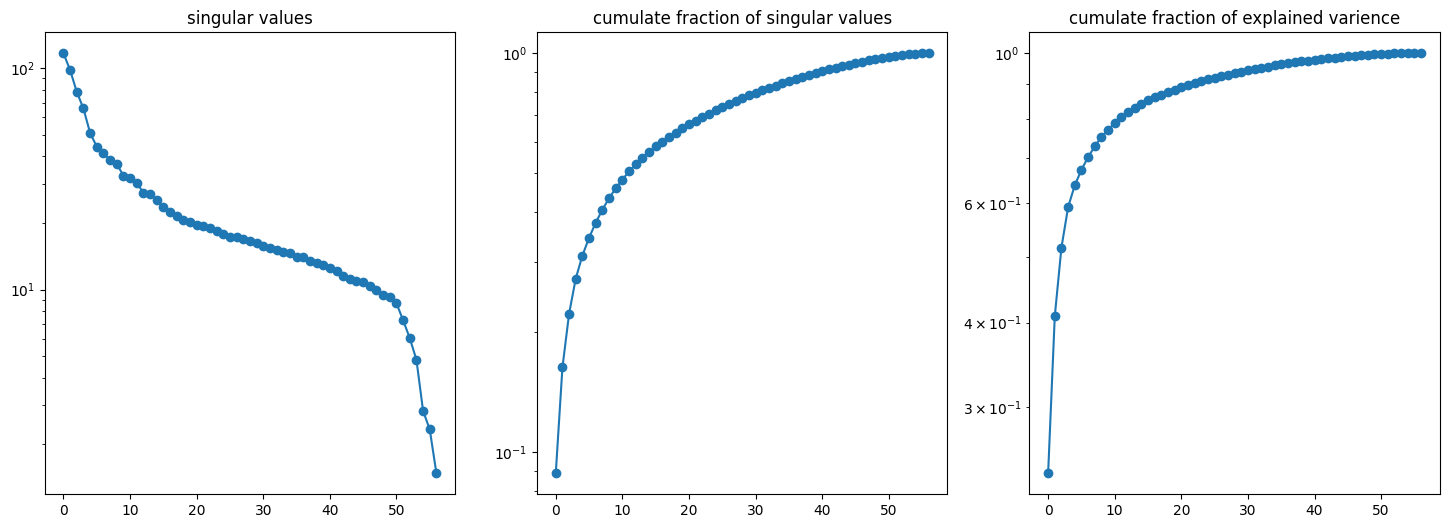

In [ ]:
# Plots
fig, axs = plt.subplots(1,3,figsize=(18,6))

axs[0].semilogy(s, 'o-')
axs[0].set_title('singular values')

axs[1].semilogy(np.cumsum(s) / np.sum(s), 'o-')
axs[1].set_title('cumulate fraction of singular values')

axs[2].semilogy(np.cumsum(s**2) / np.sum(s**2), 'o-')
axs[2].set_title('cumulate fraction of explained varience')

In [ ]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=3)
pc = pca.fit_transform(data_30s_np)

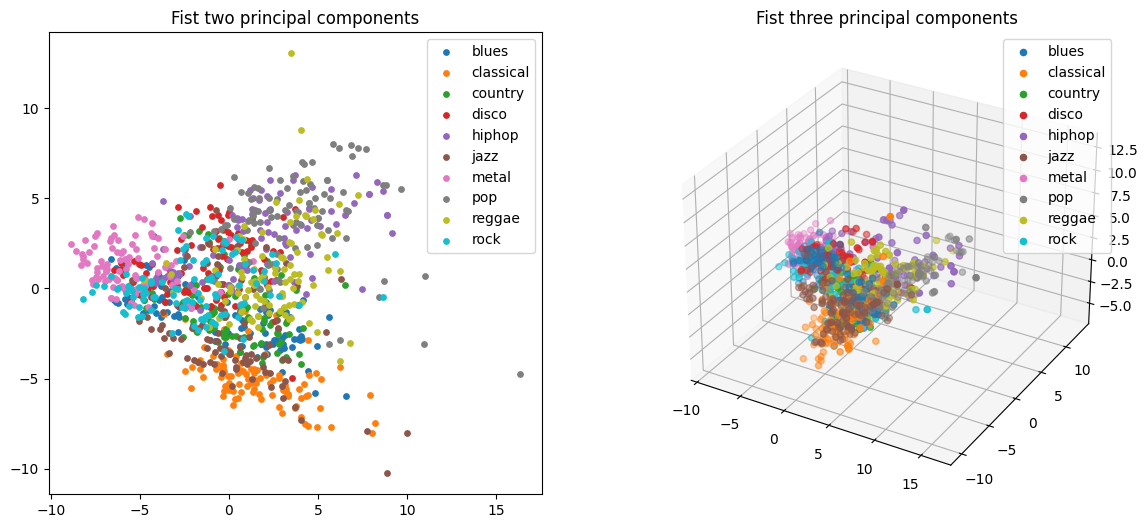

In [ ]:
# Create a figure
fig = plt.figure(figsize=(14, 6))

# Create a 2D subplot
ax_0 = fig.add_subplot(121)  # 1 row, 2 columns, first plot
ax_1 = fig.add_subplot(122, projection='3d')


# First two principal components
for label in data_30s['label'].unique():
  idxs = (labels_30s_np == label)
  ax_0.scatter(pc[idxs, 0], pc[idxs, 1], label = label, s = 15)

ax_0.legend()
ax_0.set_title("Fist two principal components")


# First three principal components
for label in data_30s['label'].unique():
  idxs = (labels_30s_np == label)
  ax_1.scatter(pc[idxs, 0], pc[idxs, 1], pc[idxs, 2], label = label)

ax_1.legend()
ax_1.set_title("Fist three principal components")

plt.show()

## 3s dataset

In [ ]:
data_3s = pd.read_csv("/content/features_3_sec.csv")
data_3s = data_3s.drop('length', axis=1)
data_3s.set_index('filename', inplace=True)
data_3s.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
filename,,,,,,,,,,,,,,,,,,,,,
blues.00000.0.wav,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
blues.00000.1.wav,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
blues.00000.2.wav,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
blues.00000.3.wav,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
blues.00000.4.wav,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


### Correlation heatmap for the features

<Axes: >

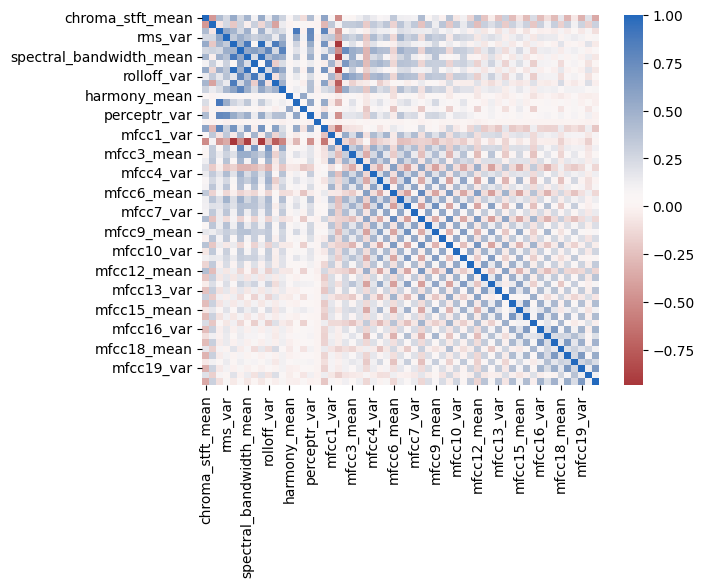

In [ ]:
sns.heatmap(data_3s.loc[:, data_3s.columns != 'label'].corr(), annot = False, cmap = 'vlag_r')

### Violin Plots

Here we can see various distributions of the features for each genre

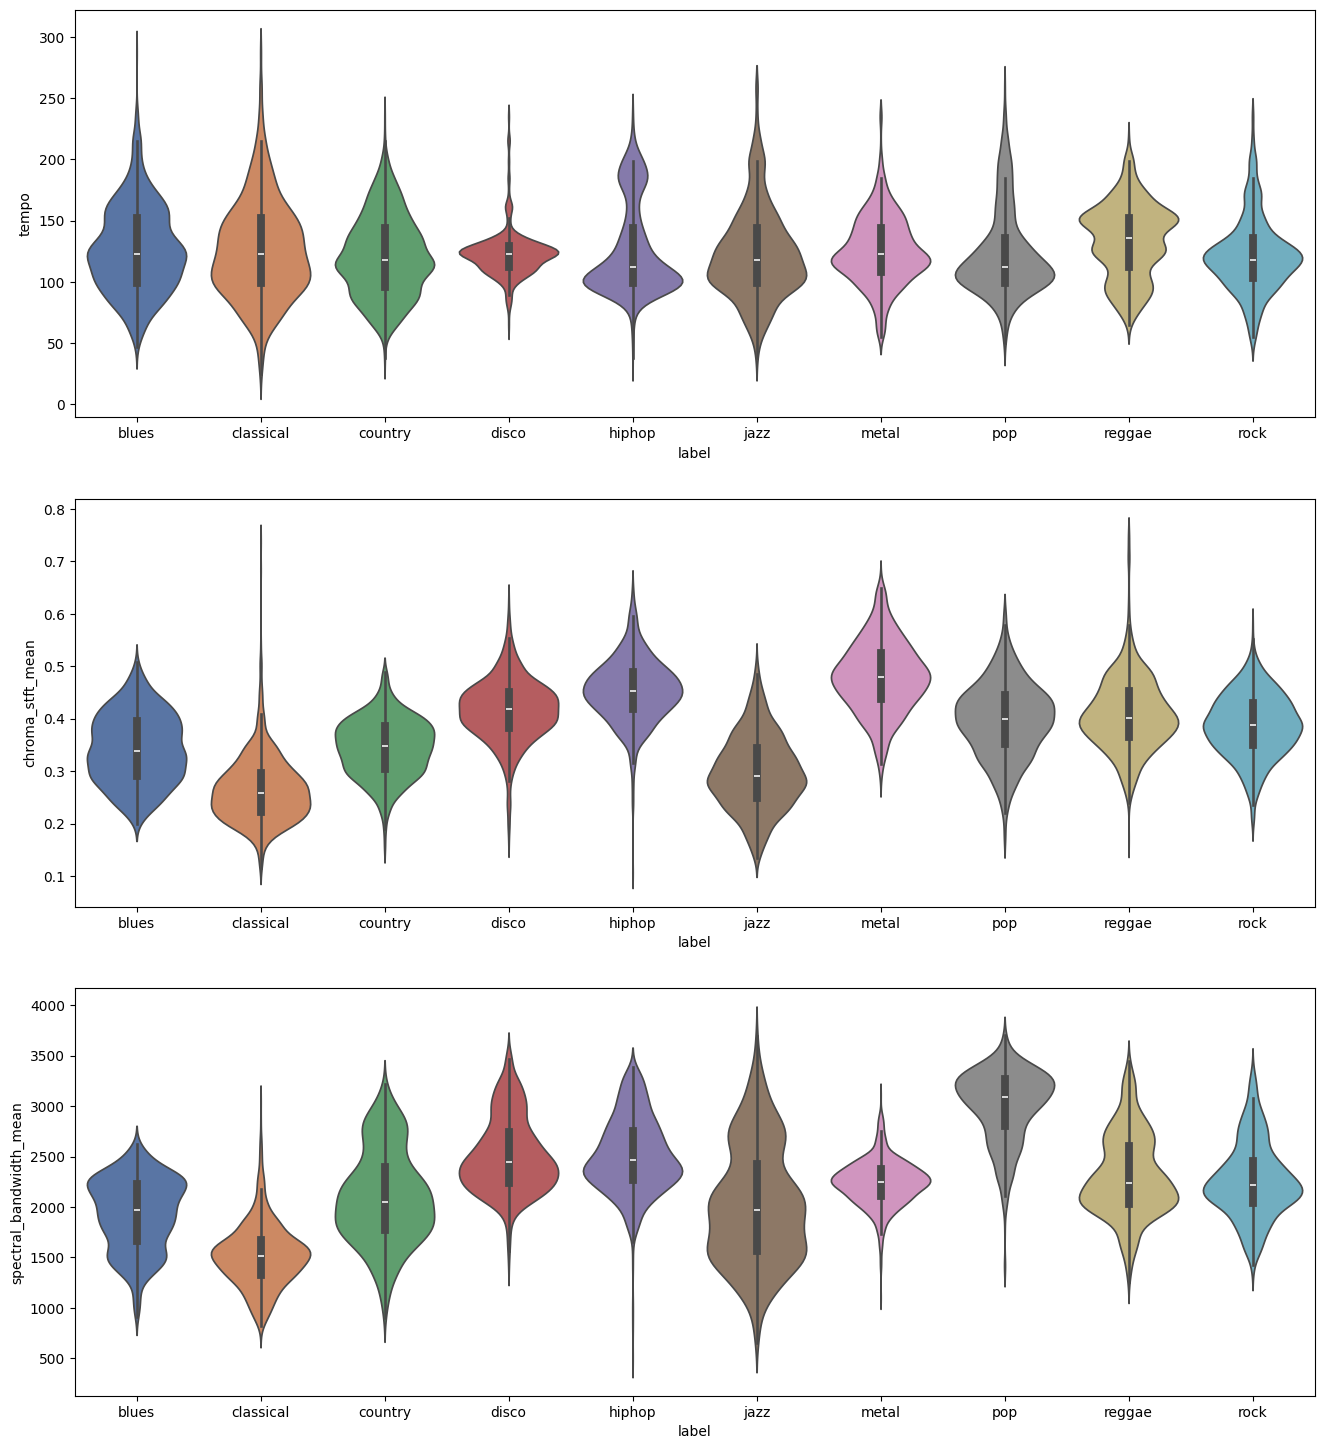

In [ ]:
distributions = ['tempo', 'chroma_stft_mean', 'spectral_bandwidth_mean']
n_distributions = len(distributions)


fig, axs = plt.subplots(1*n_distributions , 1, figsize=(16, 6*n_distributions ))
axs = axs.flatten()

for i in range(n_distributions):
  sns.violinplot(data = data_3s, ax = axs[i], x = 'label', y = distributions[i], hue='label', palette='deep')

### PCA

Here we perform the PCA on the dataset

In [ ]:
from sklearn import preprocessing

# Here we normalize our data
standard_scaler = preprocessing.StandardScaler()

data_3s_np = data_3s.loc[:, data_3s.columns != 'label'].to_numpy()
data_3s_np = standard_scaler.fit_transform(data_3s_np)

labels_3s_np = data_3s[['label']].to_numpy().reshape(-1)

In [ ]:
# SVD
U, s, VT = np.linalg.svd(data_3s_np, full_matrices = False)

Text(0.5, 1.0, 'cumulate fraction of explained varience')

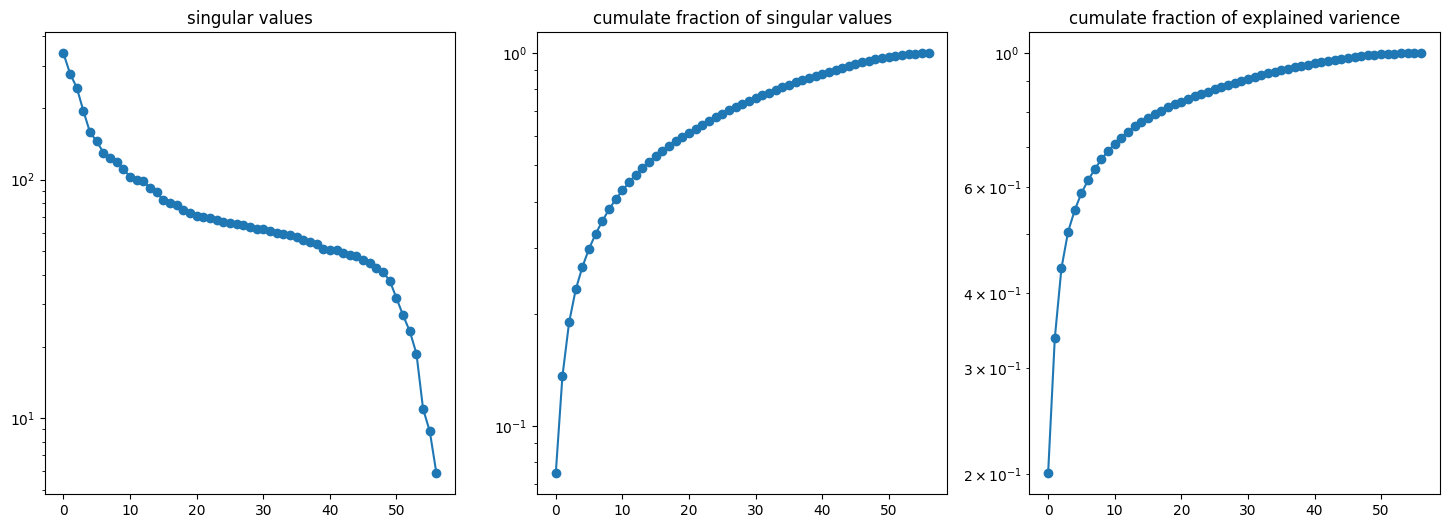

In [ ]:
# Plots
fig, axs = plt.subplots(1,3,figsize=(18,6))

axs[0].semilogy(s, 'o-')
axs[0].set_title('singular values')

axs[1].semilogy(np.cumsum(s) / np.sum(s), 'o-')
axs[1].set_title('cumulate fraction of singular values')

axs[2].semilogy(np.cumsum(s**2) / np.sum(s**2), 'o-')
axs[2].set_title('cumulate fraction of explained varience')

In [ ]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=3)
pc = pca.fit_transform(data_3s_np)

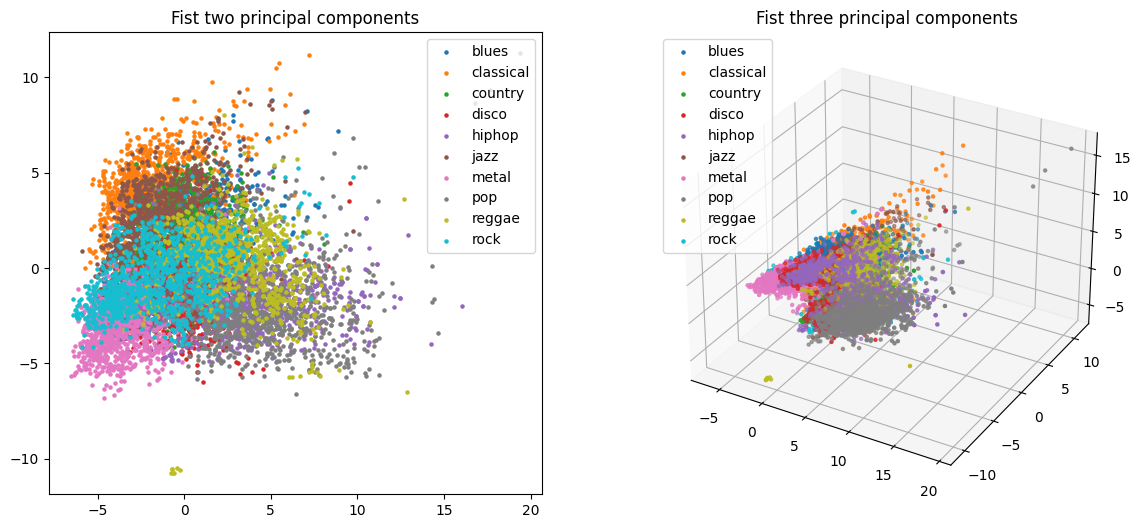

In [ ]:
# Create a figure
fig = plt.figure(figsize=(14, 6))

# Create a 2D subplot
ax_0 = fig.add_subplot(121)  # 1 row, 2 columns, first plot
ax_1 = fig.add_subplot(122, projection='3d')


# First two principal components
for label in data_3s['label'].unique():
  idxs = (labels_3s_np == label)
  ax_0.scatter(pc[idxs, 0], pc[idxs, 1], label = label, s = 5)

ax_0.legend()
ax_0.set_title("Fist two principal components")


# First three principal components
for label in data_3s['label'].unique():
  idxs = (labels_3s_np == label)
  ax_1.scatter(pc[idxs, 0], pc[idxs, 1], pc[idxs, 2], label = label, s=5)

ax_1.legend()
ax_1.set_title("Fist three principal components")

plt.show()

# Machine Learning Models

In this part of the notebook we apply various machine learning models to our data

## 30s dataset

In [50]:
data_30s = pd.read_csv("/content/features_30_sec.csv")
data_30s = data_30s.drop('length', axis=1)
data_30s.set_index('filename', inplace=True)

In [51]:
from sklearn import preprocessing

# Here we normalize our data
standard_scaler = preprocessing.StandardScaler()

data_30s_np = data_30s.loc[:, data_30s.columns != 'label'].to_numpy()
data_30s_np = standard_scaler.fit_transform(data_30s_np)

labels_30s_np = data_30s[['label']].to_numpy().reshape(-1)

### Divide the data into Training Set and Test set
- Test set = 80%
- Data set = 20%

In [52]:
X_train, X_test, y_train, y_test = train_test_split(data_30s_np, labels_30s_np, test_size=0.2, random_state=42)

### Test the machine learning approaches

In [53]:
# Building the schema for the model valutations
results_30s =  pd.DataFrame(columns=['Classifier', 'Training Time', 'Validation Accuracy', 'Test Accuracy'])
results_30s.set_index('Classifier')

,Training Time,Validation Accuracy,Test Accuracy
Classifier,,,


In [54]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
import time

repeated_cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

def test_model(model, model_name, X_train, y_train, X_test, y_test):
  # fit the data with the model
  init = time.time()
  model.fit(X_train, y_train)
  end = time.time()

  training_time = end - init        # training time

  # Computing the accuracy
  preds = model.predict(X_test)     # compute predictions
  test_accuracy = accuracy_score(y_test, preds)

  # Cross validation
  scores = cross_val_score(model, data_30s_np, labels_30s_np, cv=repeated_cv)
  validation_accuracy = scores.mean()


  results = pd.DataFrame({'Classifier': [model_name],
                  'Training Time': [training_time],
                  'Validation Accuracy': [validation_accuracy],
                  'Test Accuracy': [test_accuracy]
                  })
  return results

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
model_name = "Logistic Regression"
lg = LogisticRegression(penalty = 'l2', solver='lbfgs', multi_class='multinomial', max_iter = 400)

results_30s = pd.concat(
    [results_30s,
     test_model(lg, model_name, X_train, y_train, X_test, y_test)],
     ignore_index=True)

In [56]:
results_30s[results_30s.Classifier == model_name]

,Classifier,Training Time,Validation Accuracy,Test Accuracy
0,Logistic Regression,0.082999,0.717333,0.69


### K-nearest Neighbours

In [57]:
from sklearn.neighbors import KNeighborsClassifier

# KNN
model_name = "K-nearest Neighbours"
knn = KNeighborsClassifier(n_neighbors=1) # sometimes this explodes

results_30s = pd.concat(
    [results_30s,
     test_model(knn, model_name, X_train, y_train, X_test, y_test)],
     ignore_index=True)

In [58]:
results_30s[results_30s.Classifier == model_name]

,Classifier,Training Time,Validation Accuracy,Test Accuracy
1,K-nearest Neighbours,0.000998,0.673,0.675


### Support Vector Machine

In [59]:
from sklearn.svm import SVC

# Support Vector Machine
model_name = "Support Vector Machine"
svm = SVC(decision_function_shape="ovo")

results_30s = pd.concat(
    [results_30s,
     test_model(svm, model_name, X_train, y_train, X_test, y_test)],
     ignore_index=True)

In [60]:
results_30s[results_30s.Classifier == model_name]

,Classifier,Training Time,Validation Accuracy,Test Accuracy
2,Support Vector Machine,0.025,0.733,0.7


### Random Forests

In [61]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
model_name = "Random Forests"
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10)

results_30s = pd.concat(
    [results_30s,
     test_model(rforest, model_name, X_train, y_train, X_test, y_test)],
     ignore_index=True)

In [62]:
results_30s[results_30s.Classifier == model_name]

,Classifier,Training Time,Validation Accuracy,Test Accuracy
3,Random Forests,2.082112,0.704333,0.68


### Multilayer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

# try with 'adam' optimizer and 'lbfgs'

model_name = "Multilayer Perceptron"
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), activation = "relu")

results_30s = pd.concat(
    [results_30s,
     test_model(nn, model_name, X_train, y_train, X_test, y_test)],
     ignore_index=True)

In [64]:
results_30s[results_30s.Classifier == model_name]

,Classifier,Training Time,Validation Accuracy,Test Accuracy
4,Multilayer Perceptron,4.673,0.710667,0.715


### Final results

In [65]:
results_30s.set_index("Classifier")

results_30s

,Classifier,Training Time,Validation Accuracy,Test Accuracy
0,Logistic Regression,0.082999,0.717333,0.690
1,K-nearest Neighbours,0.000998,0.673000,0.675
2,Support Vector Machine,0.025000,0.733000,0.700
3,Random Forests,2.082112,0.704333,0.680
4,Multilayer Perceptron,4.673000,0.710667,0.715


## 3s dataset

In [29]:
data_3s = pd.read_csv("/content/features_3_sec.csv")
data_3s = data_3s.drop('length', axis=1)
data_3s.set_index('filename', inplace=True)

In [30]:
from sklearn import preprocessing

# Here we normalize our data
standard_scaler = preprocessing.StandardScaler()

data_3s_np = data_3s.loc[:, data_3s.columns != 'label'].to_numpy()
data_3s_np = standard_scaler.fit_transform(data_3s_np)

labels_3s_np = data_3s[['label']].to_numpy().reshape(-1)

### Divide the data into Training Set and Test set
- Test set = 80%
- Data set = 20%

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data_3s_np, labels_3s_np, test_size=0.2, random_state=42)

### Test the machine learning approaches

In [32]:
# Building the schema for the model valutations
results_3s =  pd.DataFrame(columns=['Classifier', 'Training Time', 'Validation Accuracy', 'Test Accuracy'])
results_3s.set_index('Classifier')

,Training Time,Validation Accuracy,Test Accuracy
Classifier,,,


In [33]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
import time

repeated_cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

def test_model(model, model_name, X_train, y_train, X_test, y_test):
  # fit the data with the model
  init = time.time()
  model.fit(X_train, y_train)
  end = time.time()

  training_time = end - init        # training time

  # Computing the accuracy
  preds = model.predict(X_test)     # compute predictions
  test_accuracy = accuracy_score(y_test, preds)

  # Cross validation
  scores = cross_val_score(model, data_3s_np, labels_3s_np, cv=repeated_cv)
  validation_accuracy = scores.mean()


  results = pd.DataFrame({'Classifier': [model_name],
                  'Training Time': [training_time],
                  'Validation Accuracy': [validation_accuracy],
                  'Test Accuracy': [test_accuracy]
                  })
  return results

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
model_name = "Logistic Regression"
lg = LogisticRegression(penalty = 'l2', solver='lbfgs', multi_class='multinomial', max_iter = 400)

results_3s = pd.concat(
    [results_3s,
     test_model(lg, model_name, X_train, y_train, X_test, y_test)],
     ignore_index=True)

In [35]:
results_3s[results_3s.Classifier == model_name]

,Classifier,Training Time,Validation Accuracy,Test Accuracy
0,Logistic Regression,0.356001,0.722956,0.736236


### K-nearest Neighbours

In [36]:
from sklearn.neighbors import KNeighborsClassifier

# KNN
model_name = "K-nearest Neighbours"
knn = KNeighborsClassifier(n_neighbors=1) # sometimes this explodes

results_3s = pd.concat(
    [results_3s,
     test_model(knn, model_name, X_train, y_train, X_test, y_test)],
     ignore_index=True)

In [37]:
results_3s[results_3s.Classifier == model_name]

,Classifier,Training Time,Validation Accuracy,Test Accuracy
1,K-nearest Neighbours,0.004,0.916817,0.91992


### Support Vector Machine

In [38]:
from sklearn.svm import SVC

# Support Vector Machine
model_name = "Support Vector Machine"
svm = SVC(decision_function_shape="ovo")

results_3s = pd.concat(
    [results_3s,
     test_model(svm, model_name, X_train, y_train, X_test, y_test)],
     ignore_index=True)

In [39]:
results_3s[results_3s.Classifier == model_name]

,Classifier,Training Time,Validation Accuracy,Test Accuracy
2,Support Vector Machine,1.402,0.865399,0.85986


### Random Forests

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
model_name = "Random Forests"
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10)

results_3s = pd.concat(
    [results_3s,
     test_model(rforest, model_name, X_train, y_train, X_test, y_test)],
     ignore_index=True)

In [41]:
results_3s[results_3s.Classifier == model_name]

,Classifier,Training Time,Validation Accuracy,Test Accuracy
3,Random Forests,22.680007,0.81368,0.822322


### Multilayer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

# try with 'adam' optimizer

model_name = "Multilayer Perceptron"
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), activation = "relu")

results_3s = pd.concat(
    [results_3s,
     test_model(nn, model_name, X_train, y_train, X_test, y_test)],
     ignore_index=True)

In [43]:
results_3s[results_3s.Classifier == model_name]

,Classifier,Training Time,Validation Accuracy,Test Accuracy
4,Multilayer Perceptron,58.281018,0.88999,0.893894


### Final results

In [44]:
results_3s.set_index("Classifier")

results_3s

,Classifier,Training Time,Validation Accuracy,Test Accuracy
0,Logistic Regression,0.356001,0.722956,0.736236
1,K-nearest Neighbours,0.004000,0.916817,0.919920
2,Support Vector Machine,1.402000,0.865399,0.859860
3,Random Forests,22.680007,0.813680,0.822322
4,Multilayer Perceptron,58.281018,0.889990,0.893894
